Duplicate key in file WindowsPath('C:/Users/tauyu/anaconda/lib/site-packages/matplotlib/mpl-data/matplotlibrc'), line 257 ('font.family:  IPAexGothic')


<IPython.core.display.Javascript object>


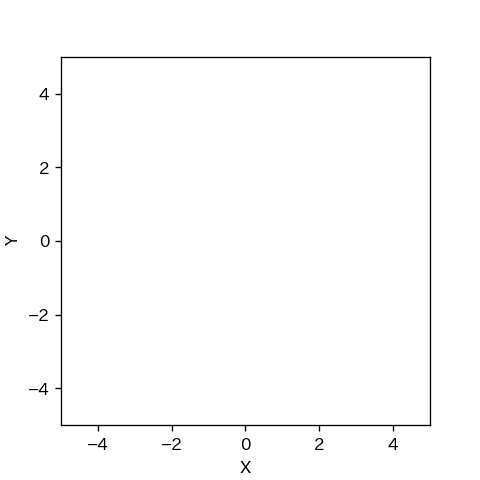

In [1]:
import sys
sys.path.append("../scripts/")
from mcl import *

In [2]:
class ResetMcl(Mcl):
    def __init__(self,envmap,init_pose,num,motion_noise_stds={"nn":0.19,"no":0.001,"on":0.13,"oo":0.2},
                distance_dev_rate=0.14,direction_dev=0.05,alpha_threshold=0.001,expansion_rate=0.2):
        super().__init__(envmap,init_pose,num,motion_noise_stds,distance_dev_rate,direction_dev)
        self.alpha_threshold=alpha_threshold
        self.expansion_rate=expansion_rate
        self.counter=0
        
    def random_reset(self):
         for p in self.particles:
                p.pose=np.array([np.random.uniform(-5.0,5,0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
                p.weight=1/len(self.particles)
    
    def sensor_resetting_draw(self,particle,landmark_pos,ell_obs,phi_obs):
             ##パーティクルの位置を決める##
                psi=np.random.uniform(-np.pi,np.pi) #ランドマークからの方角を選ぶ
                ell=norm(loc=ell_obs,scale=(ell_obs*self.distance_dev_rate)**2).rvs() #ランドマークからの距離を選ぶ
                particle.pose[0]=landmark_pos[0]+ell*math.cos(psi)
                particle.pose[1]=landmark_pos[1]+ell*math.sin(psi)
                
            ##パーティクルの向きを決める##
                phi=norm(loc=phi_obs,scale=(self.direction_dev)**2).rvs() #ランドマークが見える向きを決める
                particle.pose[2]=math.atan2(landmark_pos[1]-particle.pose[1],landmark_pos[0]-particle.pose[0])-phi
            
                particle.weight=1.0/len(self.particles) #重みを1/Nに
            
    def sensor_resetting(self,observation):
        nearest_obs=np.argmin([obs[0][0] for obs in observation]) #距離が一番近いランドマークを選択
        values, landmark_id=observation[nearest_obs]
        
        for p in self.particles:
            self.sensor_resetting_draw(p,self.map.landmarks[landmark_id].pos,*values)
            
        print(list([obs[0][0] for obs in observation]))
            
            
    def expansion_resetting(self):
        for p in self.particles:
            p.pose+=multivariate_normal(cov=np.eye(3)*(self.expansion_rate**2)).rvs()
            p.weight=1.0/len(self.particles)
            
    def observation_update(self,observation):
        for p in self.particles:
            p.observation_update(observation,self.map,self.distance_dev_rate,self.direction_dev)
     
        self.set_ml()
        
        if sum([p.weight for p in self.particles]) < self.alpha_threshold:
            self.counter += 1
            if self.counter < 5:
                self.expansion_resetting() #expansion_resettingに変更
            else:
                self.sensor_resetting(observation)
        else:
            self.counter=0
            self.resampling()

C:\Users\tauyu\anaconda\lib\site-packages\matplotlib\animation.py:889: UserWarning: Animation was deleted without rendering anything. This is most likely not intended. To prevent deletion, assign the Animation to a variable, e.g. `anim`, that exists until you have outputted the Animation using `plt.show()` or `anim.save()`.
  warnings.warn(


In [3]:
def trial_trap_kidnap(animation):
    time_interval=0.1
    world=World(30,time_interval,debug=not animation)
    
    ##地図を生成して3つランドマークを追加##
    m=Map()
    m.append_landmark(Landmark(-4,2))
    m.append_landmark(Landmark(2,-3))
    m.append_landmark(Landmark(3,3))
    world.append(m)
    
    ##ロボットを作る##
    init_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    robot_pose=np.array([np.random.uniform(-5.0,5.0),np.random.uniform(-5.0,5.0),np.random.uniform(-math.pi,math.pi)]).T
    pf=ResetMcl(m,init_pose,100)
    a=EstimationAgent(time_interval,0.2,10.0/180*math.pi,pf)
    r=Robot(robot_pose,sensor=Camera(m),agent=a,color="red",expected_stuck_time=5,expected_escape_time=5)
    world.append(r)
#, phantom_prob=0.1
    world.draw()
    return (r.pose,pf.ml.pose)

<IPython.core.display.Javascript object>


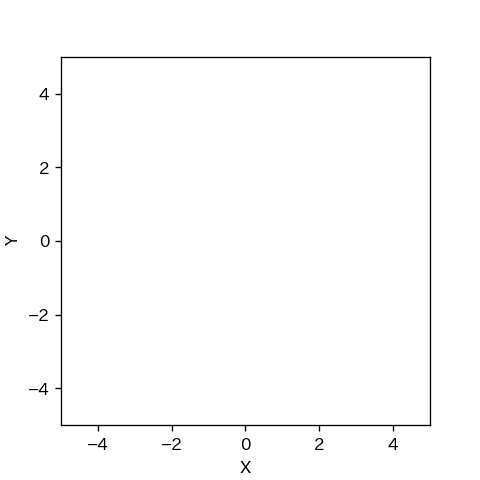

(array([-4.30449125,  3.91844726,  2.25821754]),
 array([-3.41493979,  2.88436118, -2.56457674]))

In [4]:
trial_phantom_trap_kidnap(True)

In [5]:
if __name__=='__main__': ###mclglobal1exec
    ok=0
    for i in range(1000):
        actual, estm=trial_trap_kidnap(False)
        diff = math.sqrt((actual[0]-estm[0])**2 + (actual[1]-estm[1])**2)
        print(i, "真値:",actual, "推定値:", estm, "誤差:", diff)
        if diff<=1.0:
            ok += 1
            print(ok)

[4.8157233923674125]
[1.240391760647351]
0 真値: [2.54371305 3.06399447 4.04342102] 推定値: [3.55492573 3.79487195 2.07595416] 誤差: 1.247691053100951
[4.546704516876679]
1 真値: [-1.06412539  0.62351742  6.10673788] 推定値: [-1.21144815  1.26230451 -0.23598645] 誤差: 0.6555554491179011
1
[5.204871361728957]
2 真値: [-1.41591508 -2.94872277  2.86919014] 推定値: [ 0.15606254  4.20961344 -1.83491187] 誤差: 7.328907894394898
[3.939932868000078]
[4.871571349142789]
3 真値: [-0.10212    -0.05043637 -0.61937159] 推定値: [-1.62149435 -1.63118116  0.02775342] 誤差: 2.1925447562833162
[1.668956632373793]
4 真値: [-1.01791149  2.61119849  1.12919192] 推定値: [-0.43566779  2.36920194  1.19181797] 誤差: 0.6305315639134618
2
5 真値: [ 0.92860489 -2.98328818 -0.9408017 ] 推定値: [ 2.68876136 -2.27583058  3.0653164 ] 誤差: 1.897010025986502
[6.589798598496448]
6 真値: [2.34126606 2.21372216 5.31408947] 推定値: [ 6.68517241 -1.35538649 -2.16876446] 誤差: 5.622104490344342
[4.035142125740768]
7 真値: [ 5.17620612 -1.44248514  0.31450492] 推定値: [3.505046

C:\Users\tauyu\section_advanced_localization\../scripts\ideal_robot.py:30: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(4,4))


[5.586353226359023]
20 真値: [-3.93683769 -2.95389407  0.23722018] 推定値: [ 3.79297002  1.52070889 -1.72034604] 誤差: 8.93151716900404
21 真値: [ 0.95428425 -1.85331848  5.27005911] 推定値: [ 0.28962692 -1.85836317  5.50310251] 誤差: 0.6646764733472628
6
22 真値: [-4.15629142  3.55172331  2.83228604] 推定値: [-0.4402775  -2.89397686  6.85533997] 誤差: 7.440148526350445
[3.557312906957849]
23 真値: [ 1.31716076 -0.86557938 -1.37880559] 推定値: [ 0.55958289 -4.50217962  0.64627996] 誤差: 3.7146716580745127
[0.4433880882919761]
24 真値: [-3.56647923  4.24260317  2.91725005] 推定値: [-4.33482166  3.52825315  4.2076143 ] 誤差: 1.0491167879291237
25 真値: [3.08995178 4.92298193 2.21253666] 推定値: [0.7274329  4.91752442 3.59891367] 誤差: 2.362525184411544
[3.895144475328728]
26 真値: [4.38915771 0.5384839  2.46488034] 推定値: [ 2.30659028  5.57777674 -0.92688065] 誤差: 5.452665351246687
27 真値: [ 1.50863064 -1.92834205 -0.46549163] 推定値: [ 1.9683185  -1.63575455 -0.85716055] 誤差: 0.5449040077737642
7
28 真値: [-1.42408053 -4.11736534  5.447091